In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind
import statsmodels.api as smf

def simulate_random_walks(num_trials, drift1, drift2, alpha, pop_var, dependent=False):
    """Simulate two dependent random walks

    Args:
        num_trials (int): number of trials to simulate
        drift1 (int): drift of rw1
        drift2 (int):  drift of rw2
        alpha (int): multiplactive gain of walk 1 on walk 2
        pop_var (bool): if true, introduces random sampling to direction of gain b/w walk 1 and 2
        dependent (bool, optional): _description_. Defaults to False.

    Returns:
        walk1: random walk time series
        walk2: random walk time series
        correlation: pearson correlation between walk1 & walk2
    """
    # Initialize arrays to store the random walks
    walk1 = np.zeros(num_trials)
    walk2 = np.zeros(num_trials)

    for step in range(1, num_trials):
        # Generate random steps
        step1 = np.random.normal()
        step2 = np.random.normal()

        # Add drift
        walk1[step] = walk1[step - 1] + drift1 + step1

        # Introduce randomness to dimensionality
        if pop_var is True:
            dim = 2 * np.random.sample() -1
        else: 
            dim = 1

        if dependent:
            # Make walk2 dependent on the previous timestep of walk1
            walk2[step] = walk2[step - 1] + drift2 + (alpha*dim) * walk1[step - 1] + step2
        else:
            walk2[step] = walk2[step - 1] + drift2 + step2
            
    correlation = stats.pearsonr(walk1, walk2)[0]

    return walk1, walk2, correlation

def random_walks_with_intervention(num_trials, intervention, gain, drift1, drift2, driftrnd):
    """Simulate two dependent random walks

    Args:
        num_trials (int): number of trials to simulate
        drift1 (int): drift of rw1
        drift2 (int):  drift of rw2
        alpha (int): multiplactive gain of walk 1 on walk 2
        pop_var (bool): if true, introduces random sampling to direction of gain b/w walk 1 and 2
        dependent (bool, optional): _description_. Defaults to False.

    Returns:
        _type_: _description_
    """
    # Initialize arrays to store the random walks
    walk1 = np.zeros(num_trials)
    walk2 = np.zeros(num_trials)

    if driftrnd is True:
        drift1 = np.random.uniform(low = -1, high = 1, size = 1).item()
        drift2 = np.random.uniform(low = -1, high = 1, size = 1).item()

    for step in range(1, num_trials):
        # Generate random steps
        step1 = np.random.normal()
        step2 = np.random.normal()

        # Add drift
        walk1[step] = walk1[step - 1] + drift1 + intervention[step-1] * gain + step1

        walk2[step] = walk2[step - 1] + drift2 + intervention[step-1] * gain + step2

    correlation = stats.pearsonr(walk1, walk2)[0]

    return walk1, walk2, correlation


def simulate_ar(n, phi, sigma):
    """Simulate autoregressive process

    Args:
        n (int): number of trials
        phi (float): _description_

    Returns:
        ar_process (list): timeseries of ar processes
    """
    ar_process = [0]
    for _ in range(n):
        ar_process.append(phi * ar_process[-1] + np.random.normal(0, sigma))
    return ar_process[1:]

def sobel_test(a, b, se_a, se_b):
    '''
    Sobel test for significance of mediation
    
    Args: 
        a: coefficient from X to mediator variable, M
        b: coefficient from M to Y 
        se_a: Standard error of A
        se_b: Standard error fo B

    Returns: 
        t: Sobel's test statistic
        pval : Two-tailed probability assuming normal distribution
    '''
    
    sobel = np.sqrt( (a**2)*(se_a**2) + (b**2)*(se_b**2))
    aroian  = np.sqrt( (a**2)*(se_a**2) + (b**2)*(se_b**2) + (se_b**2) *(se_a**2)) #SE2 for arioni test
    t = (a*b) / aroian
    n = 1000000
    pval = stats.t.sf(np.abs(t), n-1)*2
    return t, pval

def mediation_tests(behavioural, neural, intervention):
    intervention = pd.DataFrame({'Intercept':np.ones(len(intervention)),'X':intervention})
    regression_a= smf.OLS(neural,intervention).fit()

    neural = pd.DataFrame({'Intercept':np.ones(len(neural)),'X':neural})
    regression_b = smf.OLS(behavioural, neural).fit()

    return regression_a, regression_b

def performMediation(num_tests, num_phis, num_trials, staticIntervention):
    """Simulate mediation analysis for different values of phi with interventions as static or variable

    Args:
        num_tests (_type_): _description_
        num_phis (_type_): _description_
        num_trials (_type_): _description_
        staticIntervention (_type_): _description_
    """
    phis = np.linspace(.7, 1, num_phis)
    num_significant_mediator = np.zeros(num_phis)
    num_significant1 = np.zeros(num_phis)
    num_significant2 = np.zeros(num_phis)

    num_significant_correlation = np.zeros(num_phis)
    num_trials = np.linspace(num_trials, num_trials, 1)
    mu, sigma = 0, 1  # Mean and standard deviation

    for num_trial in num_trials:

        num_trial = int(num_trial)
        ax = plt.figure()
        
        for num, phi in enumerate(phis):
            mediation_effects = np.zeros(num_tests)
            direct1_effects = np.zeros(num_tests)
            direct2_effects = np.zeros(num_tests)
            correlation_effects = np.zeros(num_tests)

            for test in range(num_tests):

                # Step 1: Generate three independent random walks
                
                if staticIntervention is True:
                    intervention = np.random.normal(mu, sigma, num_trial)
                else:
                    intervention = simulate_ar(n = num_trial, phi = phi, sigma = sigma)
                    
                neural= simulate_ar(n = num_trial, phi = phi, sigma = 1)
                behavioural = simulate_ar(n = num_trial, phi = phi, sigma = 1)

                # Step 2: Calculate Sobel test statistics
                # Calculate the direct effect of intervention on neural
                _, p_value_neural = ttest_ind(intervention, neural)

                # Calculate the effect of intervention on behaviour
                _, p_value_behaviour = ttest_ind(behavioural, intervention)

               # Calculate the effect of neural on behaviour
                _, p_value_corr = ttest_ind(behavioural, neural)


                # Step 3: Perform the Sobel test for mediation significance
                regression_a, regression_b = mediation_tests(behavioural, neural, intervention)

                t, p_value_sobel = sobel_test(regression_a.params[1], regression_b.params[1], 
                                    regression_a.bse[1], regression_b.bse[1])

                # Store p values for computing FP rate
                mediation_effects[test] = p_value_sobel
                direct1_effects[test] = p_value_neural
                direct2_effects[test] = p_value_behaviour
                correlation_effects[test] = p_value_corr

            # Compute FP rate for correlations and mediations
            num_significant1[num] = np.sum(direct1_effects < .05)
            num_significant2[num] = np.sum(direct2_effects < .05)
            num_significant_correlation[num] = np.sum(correlation_effects < .05)
            num_significant_mediator[num] = np.sum(mediation_effects < .05)


        # Plot proportion significant correlations/mediations by Phi value
        plt.plot(num_significant1/num_tests)
        plt.xlabel('Number of Trials')
        plt.xticks([0,25], labels = [0.7, 1])
        plt.plot(num_significant_mediator/num_tests)
        plt.xlabel('Phi')
        plt.ylabel('Proportion false positive')
        plt.plot(num_significant_correlation/num_tests)
        plt.plot(num_significant2/num_tests)
        plt.ylim([-.01, 1])

def simulatePvalues(staticIntervention, causal, drift1, drift2, 
                    num_experiments, gain, num_trials, phi, sigma, plotting):
    """_summary_

    Args:
        staticIntervention (_type_): _description_
        drift (_type_): _description_
        num_experiments (_type_): _description_
        num_trials (_type_): _description_
        phi (_type_): _description_
    """
    mu = 0
    pvals = np.zeros(num_experiments)
    coeffs = np.zeros(num_experiments)
    r2 = np.zeros(num_experiments)

    for i in range(num_experiments):
        if staticIntervention is True:
            intervention = np.random.normal(mu, sigma, num_trials)
        else:
            intervention = simulate_ar(n = num_trials, phi = phi, sigma = sigma)
        
        if causal is True:
            neural, behavioural, _ = random_walks_with_intervention(num_trials, intervention, drift1 = drift1, drift2 = drift2, 
                                                                    driftrnd = False, gain = gain)
        else:
            neural, behavioural, _ = random_walks_with_intervention(num_trials, intervention, drift1 = drift1, drift2 = drift2, 
                                                        driftrnd = False, gain = 0)

        regression_a, regression_b = mediation_tests(behavioural, neural, intervention)
        coeffs[i] = regression_a.params[1]
        r2[i] = regression_a.rsquared
        _ , pvals[i] = sobel_test(regression_a.params[1], regression_b.params[1], 
                                    regression_a.bse[1], regression_b.bse[1])
    
    if plotting is True:

        _, axs = plt.subplots(2,2, figsize = (15,15))

        axs[0,0].hist(pvals)
        axs[0,0].set_title(f'P val distribution: static intervention = {staticIntervention}, causal = {causal}, phi = {phi}')
        axs[0,0].set(xlabel="pval", ylabel="count")

        axs[0,1].plot(intervention)
        axs[0,1].plot(neural)
        axs[0,1].plot(behavioural)
        axs[0,1].set_title(f'Sample experiment: static intervention = {staticIntervention}, causal = {causal}, phi = {phi}')
        axs[0,1].set(xlabel="time", ylabel="AU")

        bin_means, bin_edges, _ = stats.binned_statistic(coeffs, r2)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2

        axs[1,0].set_title('Intervention --> Behaviour Regression coefficient vs R-Squared')
        axs[1,0].set(xlabel="Regression coefficient", ylabel="R-squared")
        axs[1,0].plot(bin_centers, bin_means)

        #axs[1,1].scatter(pvals, r2)
        bin_means, bin_edges, _ = stats.binned_statistic(pvals, r2)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        plt.plot(bin_centers, bin_means)

        axs[1,1].set_title('Intervention --> Behaviour p-value vs R-squared')
        axs[1,1].set(xlabel="p-value", ylabel="R-squared")

    return pvals, coeffs, r2

def plotNoisevsGain(staticIntervention, causal, num_experiments, num_trials, min_gain, min_sigma,
                    max_gain, max_sigma):
    """ Function to plot proportion of significant mediation effects by intervention gain and noise
    
    Args:
    staticIntervention (bool): if True, intervention is drawn from a white noise process, otherwise a random walk
    causal (bool): if True, intervention provides additive gain to neural and behavioural processes

    Returns:
    pr_significant(nxm array): nxm matrix of p-values where each row corresponds to an intervention gain, and each column corresponds to
                         an intervention variance
    """

    ## Set simulation parameters
    numsteps = 10
    drift1 = 0
    drift2 = 0
    phi = 1
    alpha = .05

    ## Initialize arrays to loop over gains and sigmas, store significance testing
    gains = np.linspace(min_gain, max_gain, numsteps)
    sigmas = np.linspace(min_sigma, max_sigma, numsteps)
    pr_significant = np.zeros([numsteps,numsteps])

    ## Loop simulations for different gain-variance combinations
    for gainstep, gain in enumerate(gains):
        for sigmastep, sigma in enumerate(sigmas):
            pvals_iteration, _, _ = simulatePvalues(staticIntervention, causal, drift1, drift2, 
                                num_experiments, gain, num_trials, phi, sigma, plotting = False)
            pr_significant[gainstep,sigmastep] = np.sum(pvals_iteration <= alpha)
    
    ## Plot image
    plt.figure()
    plt.imshow(pr_significant, vmin = 0, vmax = num_experiments)
    plt.colorbar()
    plt.ylabel('intervention gain')
    plt.xticks([0, numsteps -1], [min_sigma, max_sigma])
    plt.yticks([0, numsteps -1], [min_gain, max_gain])
    plt.xlabel('intervention variance')
    
    return pr_significant

def plotNoiseGainSubtractions(acausal_static, causal_static,
                            acausal_dynamic, causal_dynamic):
    plt.figure()
    plt.imshow(acausal_dynamic - causal_dynamic, vmin = -70, vmax = 40)
    plt.colorbar()
    plt.xticks([0, 19], [0.1, 5])
    plt.yticks([0, 19], [0.1, .5])
    plt.xlabel('Intervention Noise')
    plt.ylabel('Intervention Gain')
    plt.title('Random Walk Intervention Acausal vs Causal')
    #plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\noisevsgain_dynamic', format = 'svg')

    plt.figure()
    plt.imshow(acausal_static-causal_static, vmin = -70, vmax = 40)
    plt.colorbar(label = 'Non-causal - Causal Significant Mediation tests')
    plt.title('White Noise Intervention Acausal vs Causal')
    plt.xticks([0, 19], [0.1, 5])
    plt.yticks([0, 19], [0.1, .5])
    plt.xlabel('Intervention Noise')
    plt.ylabel('Intervention Gain')
    #plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\noisevsgain_static', format = 'svg')

C:\Users\Brandon\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


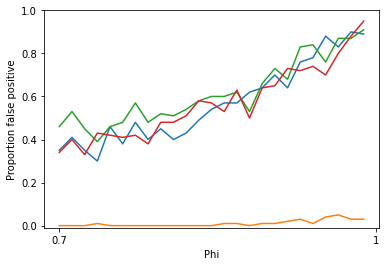

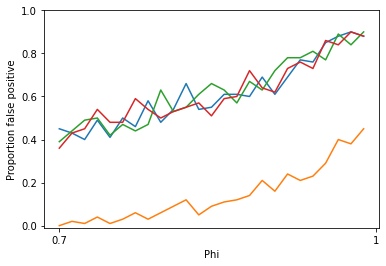

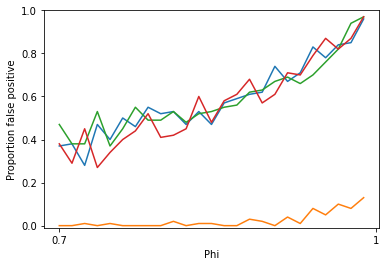

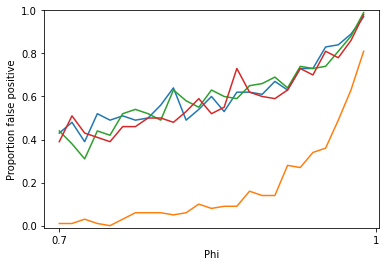

In [3]:
performMediation(num_tests = 100, num_phis = 25, num_trials = 100, staticIntervention = True)
#plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\100_trials_static_true', format = 'svg')
performMediation(num_tests = 100, num_phis = 25, num_trials = 100, staticIntervention = False)
#plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\100_trials_static_false', format = 'svg')
performMediation(num_tests = 100, num_phis = 25, num_trials = 1000, staticIntervention = True)
#plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\1000_trials_static_true', format = 'svg')
performMediation(num_tests = 100, num_phis = 25, num_trials = 1000, staticIntervention = False)
#plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\1000_trials_static_false', format = 'svg')


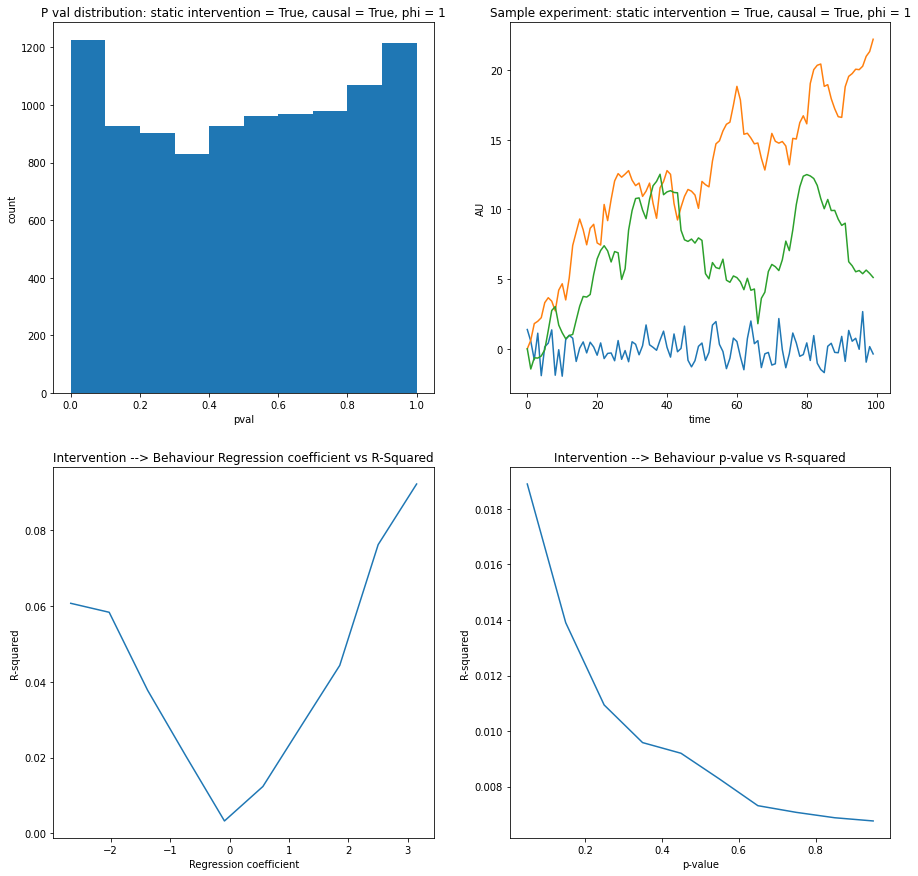

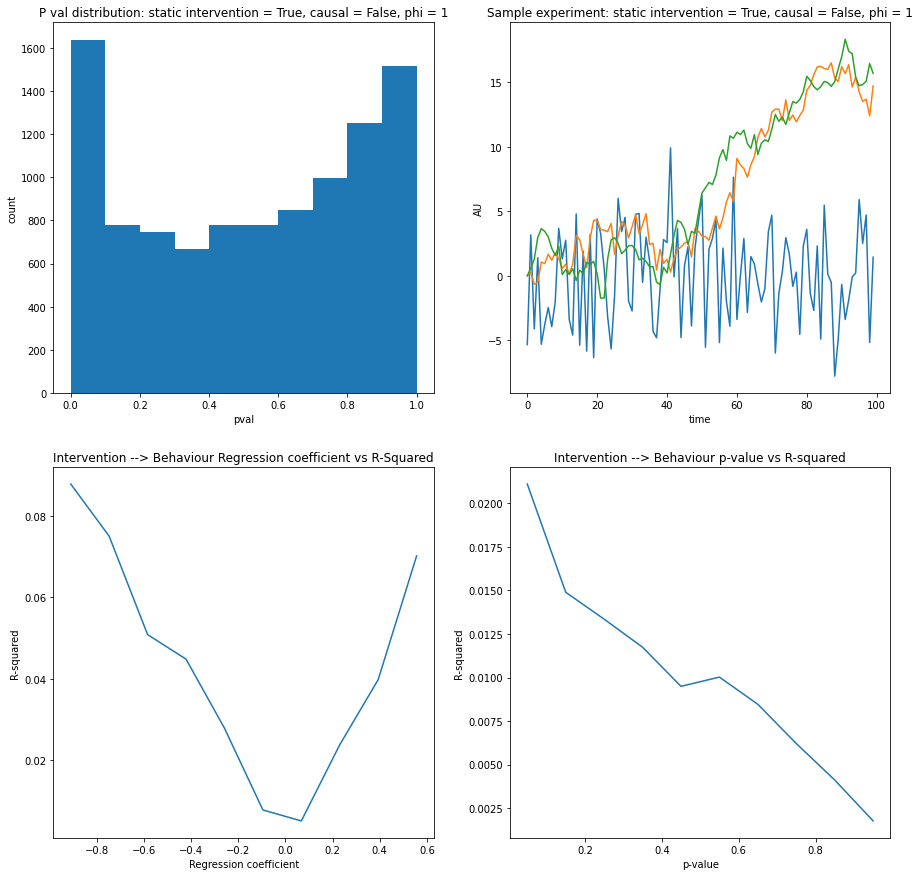

In [49]:
## Get distribution of p values for random walks with drift
simulatePvalues(staticIntervention = True, causal = True, drift1 = .1, drift2 = .1, sigma = 1,
                num_experiments = 10000, gain = .1, num_trials = 100, phi = 1)
plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\Pval_sim_static_causal_sig1', format = 'svg')

simulatePvalues(staticIntervention = True, causal = False, drift1 = .1, drift2 = .1, sigma = 4,
                num_experiments = 10000, gain = .1, num_trials = 100, phi = 1)
plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\Pval_sim_static_noncausal_sig1', format = 'svg')


In [3]:
## Get distribution of p values for random walks with drift
simulatePvalues(staticIntervention = False, causal = True, drift1 = 0.1, drift2 = 0.1, sigma = 4,
                num_experiments = 10000, gain = .1, num_trials = 100, phi = .1 ,plotting = True)
#plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\Pval_sim_dynamic_causal_sig1', format = 'svg')

simulatePvalues(staticIntervention = False, causal = False, drift1 = 0, drift2 = 0, sigma = 4,
                num_experiments = 10000, gain = .1, num_trials = 100, phi = .1)
#plt.savefig(rf'C:\Users\Brandon\Desktop\PhD\Ergodicity\Figures\Pval_sim_dynamic_noncausal_sig1', format = 'svg')

TypeError: simulatePvalues() missing 1 required positional argument: 'plotting'

In [ ]:
simulatePvalues(staticIntervention = True, num_experiments=10000, drift1 = 0, drift2 = 0, sigma = 4,
                num_trials = 100, gain = .01, phi = .1, causal = True)

simulatePvalues(staticIntervention = False, num_experiments=10000, drift1 = 0, drift2 = 0, sigma = 4,
                 num_trials = 100, gain = .01, phi = 1, causal = True)


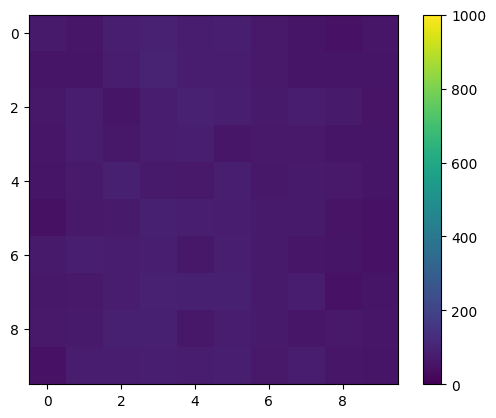

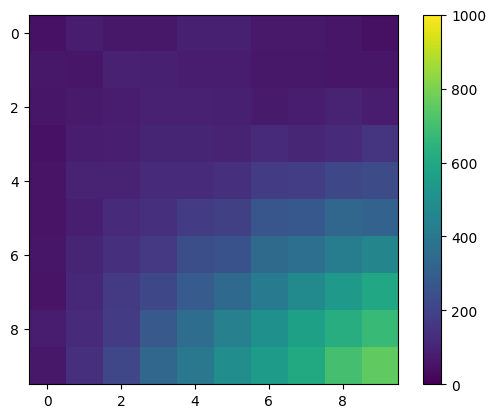

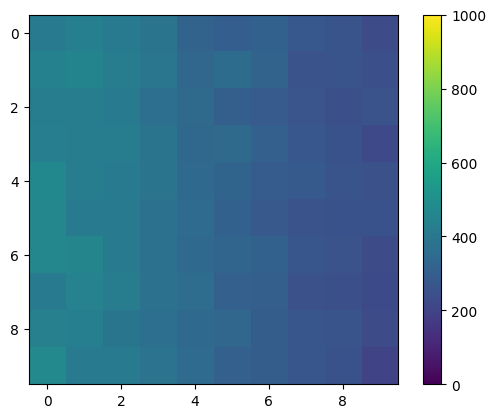

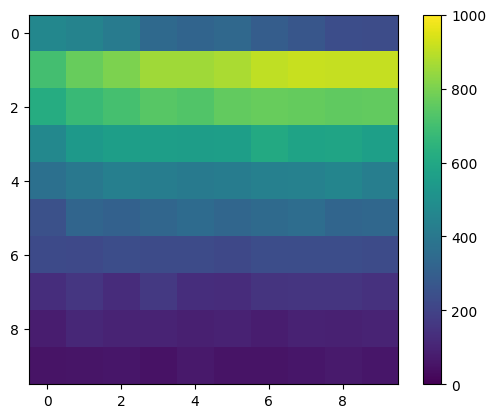

In [39]:
acausal_static = plotNoisevsGain(staticIntervention = True, causal = False, 
num_experiments = 1000, num_trials = 100, max_gain = .5, max_sigma = 5)
causal_static = plotNoisevsGain(staticIntervention = True, causal = True, 
num_experiments = 1000, num_trials = 100, max_gain = .5, max_sigma = 5)
acausal_dynamic = plotNoisevsGain(staticIntervention = False, causal = False, 
num_experiments = 1000, num_trials = 100, max_gain = .5, max_sigma = 5)
causal_dynamic = plotNoisevsGain(staticIntervention = False, causal = True, 
num_experiments = 1000, num_trials = 100, max_gain = .5, max_sigma = 5)



Text(0.5, 1.0, 'gain 0.03-.5')

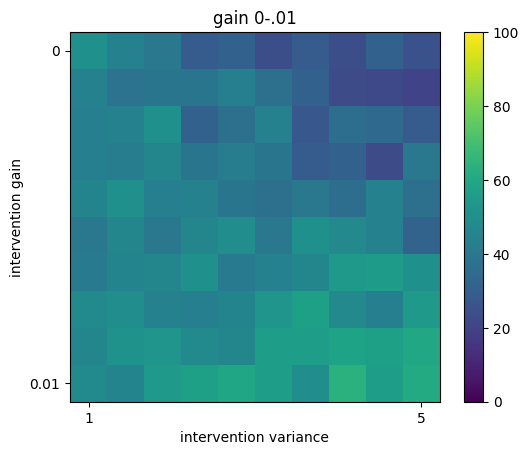

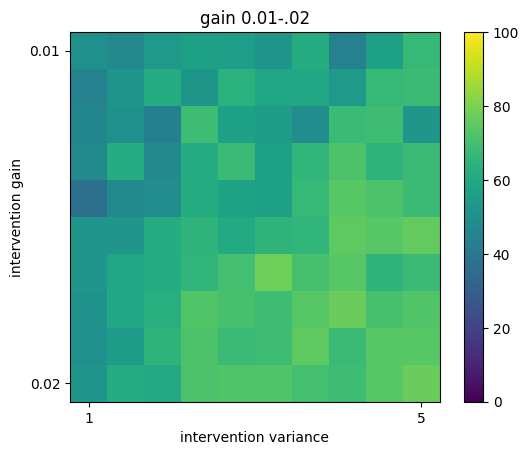

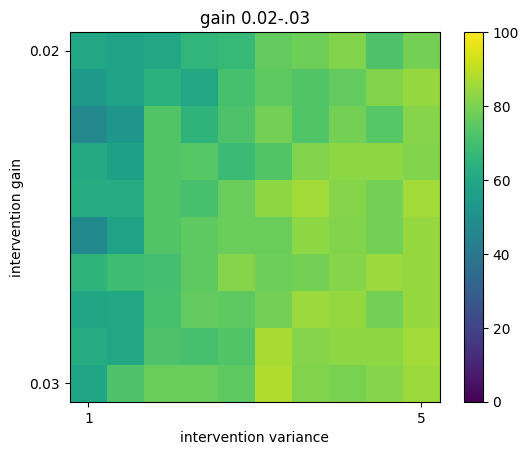

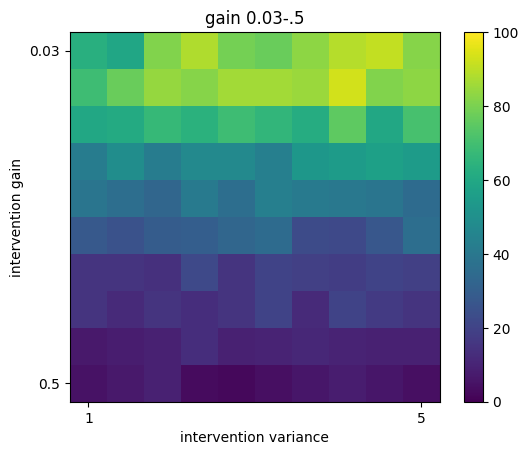

In [72]:
causal_dynamic = plotNoisevsGain(staticIntervention = False, causal = True, 
num_experiments = 100, num_trials = 100, min_gain = 0, max_gain = .01, min_sigma = 1, max_sigma = 5)
plt.title('gain 0-.01')

causal_dynamic = plotNoisevsGain(staticIntervention = False, causal = True, 
num_experiments = 100, num_trials = 100, min_gain = 0.01, max_gain = .02, min_sigma = 1, max_sigma = 5)
plt.title('gain 0.01-.02')

causal_dynamic = plotNoisevsGain(staticIntervention = False, causal = True, 
num_experiments = 100, num_trials = 100, min_gain = 0.02, max_gain = .03, min_sigma = 1, max_sigma = 5)
plt.title('gain 0.02-.03')

causal_dynamic = plotNoisevsGain(staticIntervention = False, causal = True, 
num_experiments = 100, num_trials = 100, min_gain = 0.03, max_gain = .5, min_sigma = 1, max_sigma = 5)
plt.title('gain 0.03-.5')

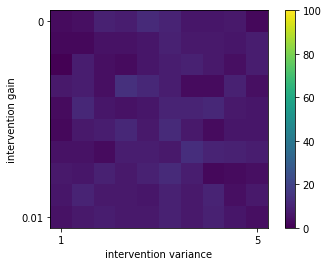

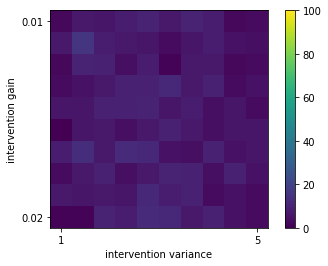

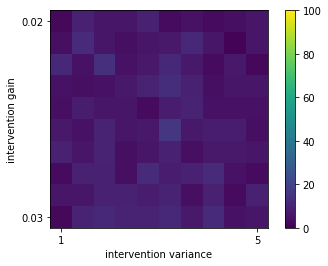

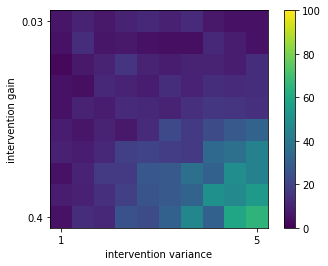

In [2]:
causal_dynamic = plotNoisevsGain(staticIntervention = True, causal = True, 
num_experiments = 100, num_trials = 100, min_gain = 0, max_gain = .01, min_sigma = 1, max_sigma = 5)

causal_dynamic = plotNoisevsGain(staticIntervention = True, causal = True, 
num_experiments = 100, num_trials = 100, min_gain = 0.01, max_gain = .02, min_sigma = 1, max_sigma = 5)

causal_dynamic = plotNoisevsGain(staticIntervention = True, causal = True, 
num_experiments = 100, num_trials = 100, min_gain = 0.02, max_gain = .03, min_sigma = 1, max_sigma = 5)

causal_dynamic = plotNoisevsGain(staticIntervention = True, causal = True, 
num_experiments = 100, num_trials = 100, min_gain = 0.03, max_gain = .4, min_sigma = 1, max_sigma = 5)


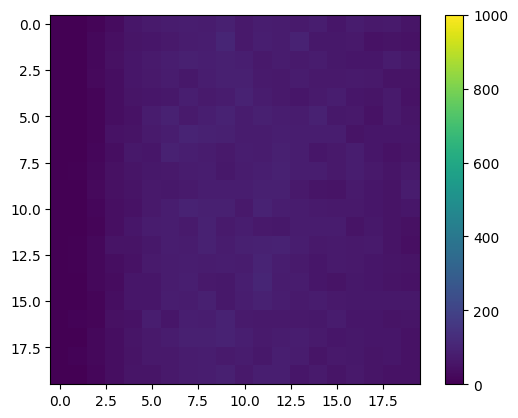

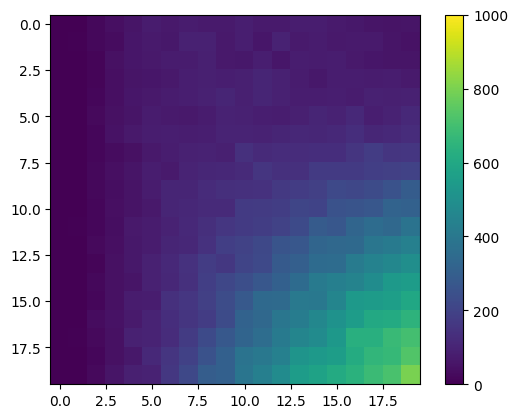

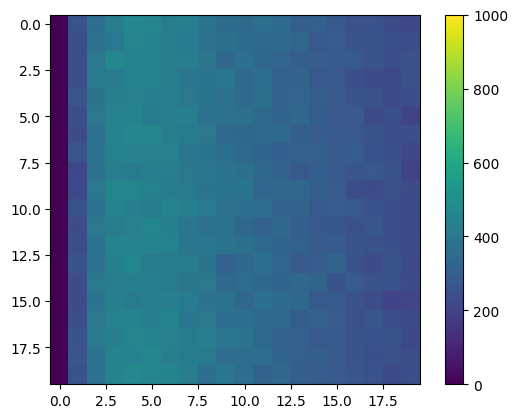

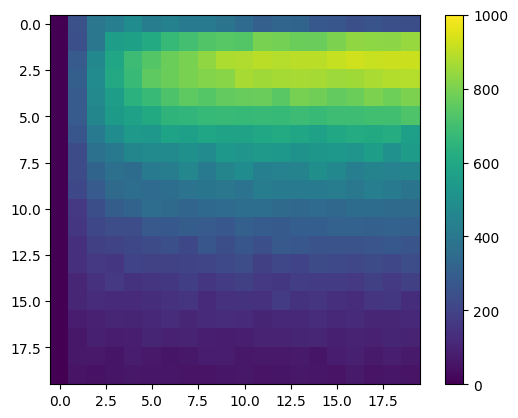

In [19]:
acausal_static = plotNoisevsGain(staticIntervention = True, causal = False)
causal_static = plotNoisevsGain(staticIntervention = True, causal = True)
acausal_dynamic = plotNoisevsGain(staticIntervention = False, causal = False)
causal_dynamic = plotNoisevsGain(staticIntervention = False, causal = True)

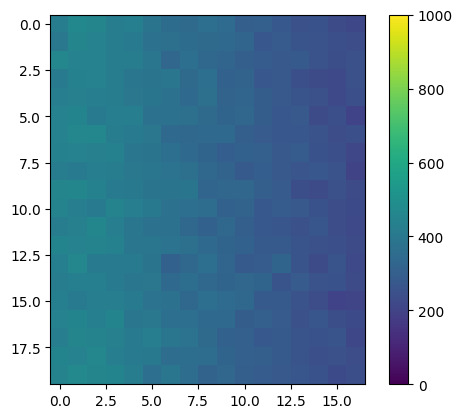

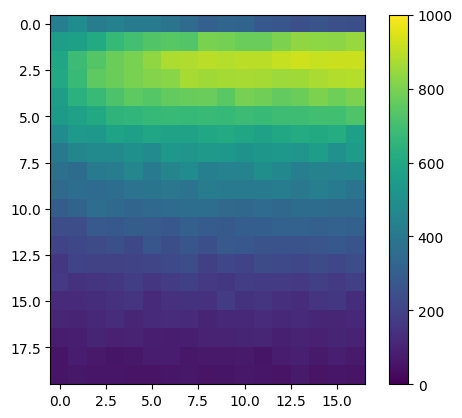

In [29]:
plt.figure()
plt.imshow(acausal_dynamic[:,3:], vmin = 0, vmax = 1000)
plt.colorbar()
plt.figure()
plt.imshow(causal_dynamic[:,3:], vmin = 0, vmax = 1000)
plt.colorbar()
